In [ ]:
# a = []
# while(1):
#   a.append('1')

In [ ]:
 import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", x_test.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing data shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 1)


In [ ]:
num_classes = len(np.unique(y_train))
print("Number of unique classes:", num_classes)

Number of unique classes: 10


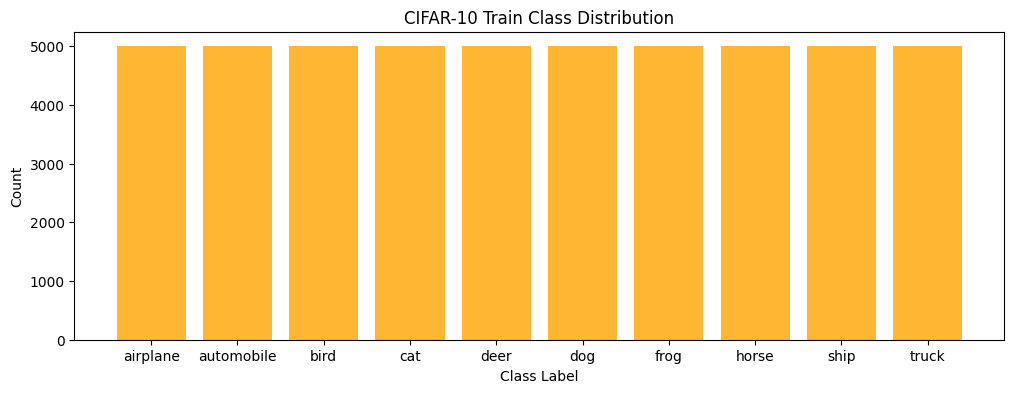

In [ ]:
class_counts = np.bincount(y_train.flatten().astype(int))
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(class_labels, class_counts, align='center', color='orange', alpha=0.8)
ax.set_xlabel('Class Label')
ax.set_ylabel('Count')
ax.set_title('CIFAR-10 Train Class Distribution')
plt.show()



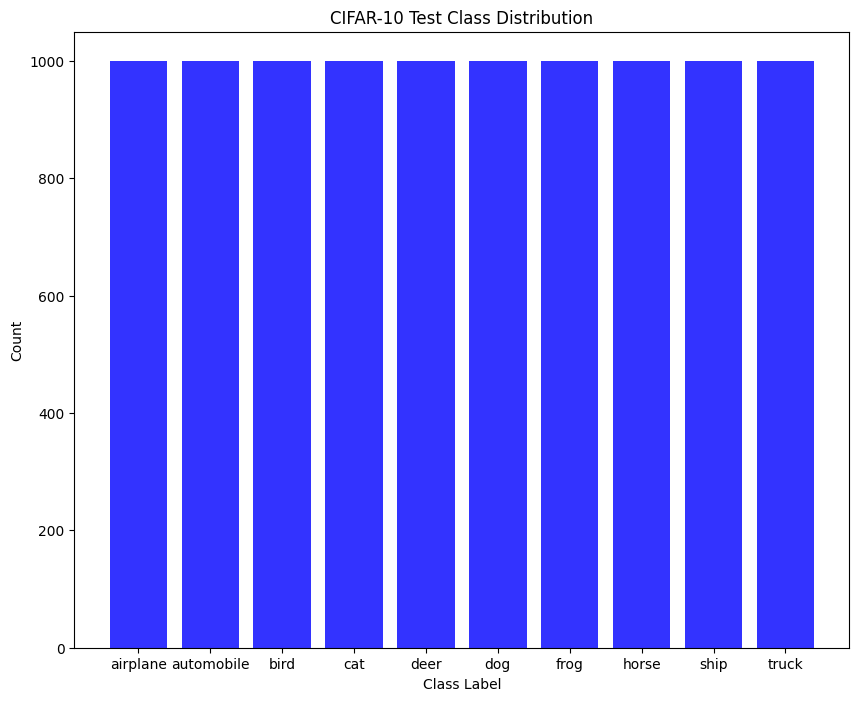

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
class_counts = np.bincount(y_test.flatten().astype(int))
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(class_labels, class_counts, align='center', color='blue', alpha=0.8)
ax.set_xlabel('Class Label')
ax.set_ylabel('Count')
ax.set_title('CIFAR-10 Test Class Distribution')
plt.show()


In [ ]:
# Normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0


In [ ]:
# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

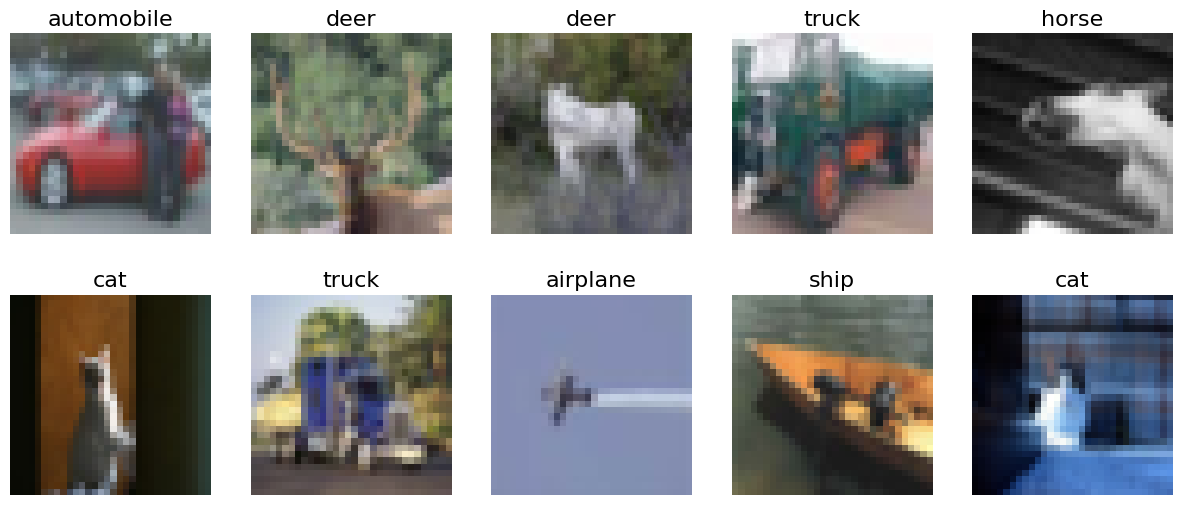

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()
for i in range(10):
    random_idx = np.random.randint(len(x_train))
    axes[i].imshow(x_train[random_idx])
    axes[i].set_title(class_labels[np.argmax(y_train[random_idx])], fontsize=16)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.3)
plt.show()

## Implementing CNN

In [ ]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## KFold Cross Validation



In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score

kfold = KFold(n_splits=2, shuffle=True, random_state=42)
x_train_reshape = x_train.reshape(x_train.shape[0], -1)
y_train_reshape = np.argmax(y_train, axis=1)

accuracies = []
f1_scores = []
precisions = []

for train_index, val_index in kfold.split(x_train_reshape):
    model = create_model()
    model.fit(x_train[train_index], y_train[train_index], epochs=2, verbose=1)
    y_pred = np.argmax(model.predict(x_train[val_index]), axis=1)
    
    accuracy = accuracy_score(y_train_reshape[val_index], y_pred)
    f1 = f1_score(y_train_reshape[val_index], y_pred, average='weighted')
    precision = precision_score(y_train_reshape[val_index], y_pred, average='weighted')
    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)

Epoch 1/2
782/782 [==============================] - 4s 4ms/step - loss: 1.6198 - accuracy: 0.4081
Epoch 2/2
782/782 [==============================] - 1s 2ms/step
Epoch 1/2
782/782 [==============================] - 4s 4ms/step - loss: 1.6081 - accuracy: 0.4134
Epoch 2/2
782/782 [==============================] - 1s 2ms/step


In [ ]:
print("Cross-validation:")
print("Accuracy:", np.mean(accuracies))
print("F1-score:", np.mean(f1_scores))
print("Precision:", np.mean(precisions))

Cross-validation:
Accuracy: 0.58358
F1-score: 0.5802435319519185
Precision: 0.5940686327183218


## holdout Testing

In [ ]:
from sklearn.model_selection import train_test_split

x_train_holdout, x_val_holdout, y_train_holdout, y_val_holdout = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

model_holdout = create_model()
model_holdout.fit(x_train_holdout, y_train_holdout, epochs=2, verbose=1)

y_pred_holdout = np.argmax(model_holdout.predict(x_val_holdout), axis=1)

accuracy_holdout = accuracy_score(np.argmax(y_val_holdout, axis=1), y_pred_holdout)
f1_holdout = f1_score(np.argmax(y_val_holdout, axis=1), y_pred_holdout, average='weighted')
precision_holdout = precision_score(np.argmax(y_val_holdout, axis=1), y_pred_holdout, average='weighted')


Epoch 1/2
1250/1250 [==============================] - 5s 3ms/step - loss: 1.4563 - accuracy: 0.4783
Epoch 2/2
313/313 [==============================] - 1s 2ms/step


In [ ]:
print("Holdout Testing:")
print("Accuracy:", accuracy_holdout)
print("F1-score:", f1_holdout)
print("Precision:", precision_holdout)

Holdout Testing:
Accuracy: 0.635
F1-score: 0.6336018333641567
Precision: 0.6479176559537386


## Bootstrapping

In [ ]:
from sklearn.utils import resample

n_iterations = 2
n_size = int(len(x_train) * 0.8)

accuracy_bootstrap = []
f1_bootstrap = []
precision_bootstrap = []

for i in range(n_iterations):
  x_bootstrap, y_bootstrap = resample(x_train, y_train, n_samples=n_size, replace=True, random_state=i)
  model_bootstrap = create_model()
  model_bootstrap.fit(x_bootstrap, y_bootstrap, epochs=2, verbose=1)
  y_pred_bootstrap = np.argmax(model_bootstrap.predict(x_test), axis=1)
  accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_bootstrap)
  f1 = f1_score(np.argmax(y_test, axis=1), y_pred_bootstrap, average='weighted')
  precision = precision_score(np.argmax(y_test, axis=1), y_pred_bootstrap, average='weighted')

  accuracy_bootstrap.append(accuracy)
  f1_bootstrap.append(f1)
  precision_bootstrap.append(precision)

Epoch 1/2
1250/1250 [==============================] - 6s 3ms/step - loss: 1.4019 - accuracy: 0.4986
Epoch 2/2
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
1250/1250 [==============================] - 6s 3ms/step - loss: 1.4371 - accuracy: 0.4849
Epoch 2/2
313/313 [==============================] - 1s 2ms/step


In [ ]:
print("Bootstrapping:")
print("Accuracy:", np.mean(accuracy_bootstrap))
print("F1-score:", np.mean(f1_bootstrap))
print("Precision:", np.mean(precision_bootstrap))

Bootstrapping:
Accuracy: 0.6274
F1-score: 0.6235320030129545
Precision: 0.6342229043349084


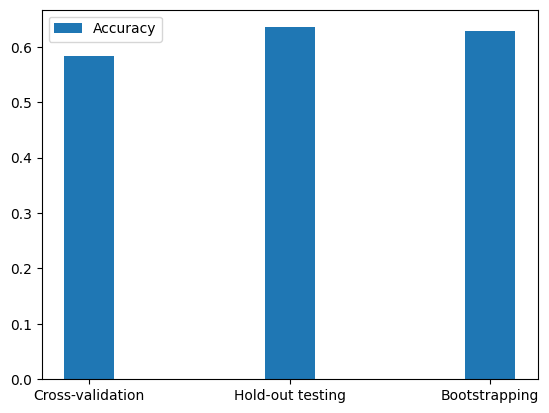

In [ ]:
labels = ['Cross-validation', 'Hold-out testing', 'Bootstrapping']
accuracy_values = [np.mean(accuracies), accuracy_holdout, np.mean(accuracy_bootstrap)]
fig, ax = plt.subplots()
x = np.arange(len(labels))
width = 0.25
rects1 = ax.bar(x, accuracy_values, width, label='Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

plt.show()

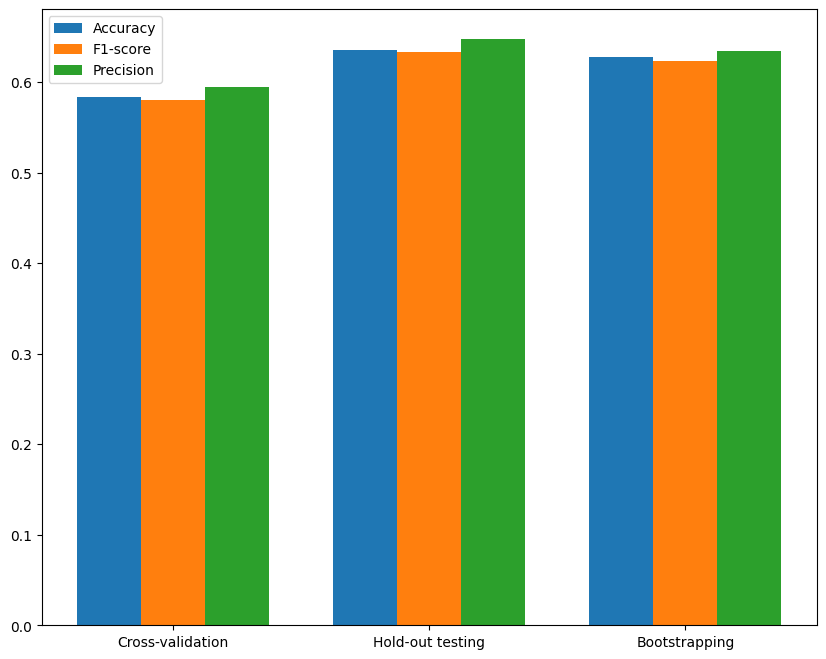

In [ ]:
labels = ['Cross-validation', 'Hold-out testing', 'Bootstrapping']
accuracy_values = [np.mean(accuracies), accuracy_holdout, np.mean(accuracy_bootstrap)]
f1_values = [np.mean(f1_scores), f1_holdout, np.mean(f1_bootstrap)]
precision_values = [np.mean(precisions), precision_holdout, np.mean(precision_bootstrap)]

fig, ax = plt.subplots(figsize=(10,8))
x = np.arange(len(labels))
width = 0.25

rects1 = ax.bar(x - width, accuracy_values, width, label='Accuracy')
rects2 = ax.bar(x, f1_values, width, label='F1-score')
rects3 = ax.bar(x + width, precision_values, width, label='Precision')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()